In [1]:
import sys
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import optimizers
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K

from sklearn.metrics import confusion_matrix
import itertools

from tqdm import tqdm

# reserve only the 30% of the GPU memory
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
width = 50
height = 10
channels = 4 #3
classes = 4
dataset_dir = '/data/user/adipilat/ParticleID/genEvts/new_datasets/padded/'
save_dir = '/data/user/adipilat/ParticleID/models/'
plot_dir = '/data/user/adipilat/ParticleID/plots/new/'
padding = 'padding' + str(height)
model_name= padding +'_PCAModel'
history_name = model_name + '_history'

# This dictionary should be extended to new classes and antiparticles
class_labels = {22:0, 11:1, 13:2, 211:3}
class_names = np.array(['γ', 'e$^{-}$', 'μ$^{-}$', 'π$^{+}$'])

In [3]:
# arrays of data needed for training

data_array = []
pid_array = []
en_array = []

# read dataset
files = [f for f in os.listdir(dataset_dir) if f.endswith("h5")]

for name in tqdm(files):
    print("Reading file", name)
    data = pd.read_hdf(dataset_dir + name)
    num_tracks_start = int(0.9 * data.trackster.max())
    num_tracks = int(data.trackster.max()) #with the new dataset, we'll split into training and test
    
    for i in range(num_tracks_start+1, num_tracks+1):
        track = data[data['trackster'] == i]
#         img = np.array([track.E.values, track.eta.values, track.phi.values]).T.reshape(width, height, channels)
#         img = np.array([track.E.values, np.abs(track.eta.values-track.eta_mean.values), np.abs(track.phi.values-track.phi_mean.values)]).T.reshape(width, height, channels)
        img = np.array([track.E.values, track.x_pca.values, track.y_pca.values, track.z_pca.values]).T.reshape(width, height, channels)
        pid_vals, pid_counts = np.unique(track[track['cpID'] != 0].cpID, return_counts=True)
        pid_index = np.argmax(pid_counts)
        pid = int(pid_vals[pid_index])
        pid = class_labels[pid]
        en_value = track[track['genE'] != 0].genE.max()
        data_array.append(img)
        pid_array.append(pid)
        en_array.append(en_value)

data_array = np.array(data_array)
pid_array = np.array(pid_array)
pid_array_cat = keras.utils.to_categorical(pid_array, num_classes=classes, dtype='float32')
en_array = np.array(en_array)

  0%|          | 0/4 [00:00<?, ?it/s]

Reading file pion_c_newPadded.h5


 25%|██▌       | 1/4 [00:06<00:18,  6.24s/it]

Reading file gamma_newPadded.h5


 50%|█████     | 2/4 [00:12<00:12,  6.38s/it]

Reading file electron_newPadded.h5


 75%|███████▌  | 3/4 [00:19<00:06,  6.32s/it]

Reading file muon_newPadded.h5


100%|██████████| 4/4 [00:25<00:00,  6.27s/it]


In [4]:
print(data_array.shape)
print(pid_array.shape)
print(en_array.shape)

(4000, 50, 10, 4)
(4000,)
(4000,)


In [5]:
####### NORMALIZE THE ENERGY ########

mean_en = 213.90352475881576
std_en = 108.05413626100672

print('Mean Energy Value: {}'.format(mean_en))
print('Std Energy Value: {}'.format(std_en))

en_array_norm = (en_array - mean_en)/std_en

Mean Energy Value: 213.90352475881576
Std Energy Value: 108.05413626100672


In [6]:
# Load the trained model
model = load_model(save_dir + model_name + '.h5')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 50, 10, 4)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 10, 3)    63          input[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 50, 10, 3)    84          conv1[0][0]                      
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, 50, 10, 3)    84          conv2[0][0]                      
__________________________________________________________________________________________________
flatten_1 

In [7]:
# Score trained model

scores = model.evaluate(data_array, {'pid_output': pid_array_cat, 'enreg_output': en_array_norm}, verbose=1)
print("Scores: {}".format(scores))

4000/4000 [==============================] - 1s 290us/step
Scores: [0.6468992055058479, 0.3705169704244472, 0.27638223541900514, 0.7995, 0.27638223541900514]


In [8]:
# Perform inference

results = model.predict(data_array)

print('****** PID START*******')
print('True Particle IDs= {} '.format(pid_array))
pid_results = results[0]
pid_predicted = np.argmax(pid_results, axis=1)
print('Predicted Particle ID Probabilities= {} '.format(pid_results))
print('Predicted Particle IDs= {} '.format(pid_predicted))
print('****** PID END*******')

print('****** ENREG START*******')
print('True Particle Energies= {} '.format(en_array))
enreg_results = results[1]
enreg_results = (enreg_results * std_en) + mean_en
enreg_results = np.squeeze(enreg_results)
print('Predicted Particle Energies= {}'.format(enreg_results))
print('****** ENREG END*******')

****** PID START*******
True Particle IDs= [3 3 3 ... 2 2 2] 
Predicted Particle ID Probabilities= [[1.5978416e-07 1.1174830e-08 3.3385102e-05 9.9996650e-01]
 [4.7578952e-14 3.3223097e-16 1.0811915e-08 1.0000000e+00]
 [2.2380361e-06 1.7373841e-07 2.1690023e-05 9.9997592e-01]
 ...
 [1.1368189e-05 2.4443631e-05 9.9926382e-01 7.0030539e-04]
 [3.1414206e-06 7.1280438e-06 9.9955481e-01 4.3491492e-04]
 [1.1466661e-05 2.4640693e-05 9.9925774e-01 7.0610241e-04]] 
Predicted Particle IDs= [3 3 3 ... 2 2 2] 
****** PID END*******
****** ENREG START*******
True Particle Energies= [216.82531738 393.25973511 227.68838501 ...  49.84970474 374.22885132
  61.58562851] 
Predicted Particle Energies= [213.3398  368.9754  223.36928 ... 202.57616 211.51581 202.8715 ]
****** ENREG END*******


In [9]:
gamma_true_en = en_array[pid_array==0]
electron_true_en = en_array[pid_array==1]
muon_true_en = en_array[pid_array==2]
pion_c_true_en = en_array[pid_array==3]

gamma_reco_en = enreg_results[pid_array==0]
electron_reco_en = enreg_results[pid_array==1]
muon_reco_en = enreg_results[pid_array==2]
pion_c_reco_en = enreg_results[pid_array==3]

In [10]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=13, y=1.04)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black", fontsize=12)

    plt.ylabel('True class', labelpad=10, fontsize=13)
    plt.xlabel('Predicted class', labelpad=10, fontsize=13)
    plt.tight_layout()

Confusion matrix
[[0.65 0.35 0.   0.  ]
 [0.41 0.58 0.   0.  ]
 [0.   0.   0.99 0.01]
 [0.02 0.   0.01 0.97]]


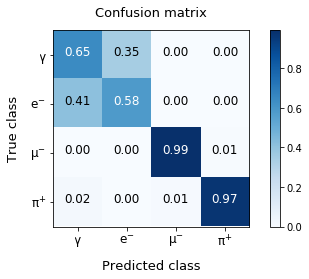

In [11]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(pid_array, pid_predicted)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(0)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Confusion matrix')
plt.savefig(plot_dir + model_name + '_confusion_matrix.pdf', format='pdf')
plt.show()

In [12]:
# #gamma's energy
# fig1 = plt.figure(1)
# plt.scatter(gamma_true_en, gamma_reco_en, color='red')
# plt.title('Gamma Energy Regression', y=1.04)
# plt.xlabel('True Energy', labelpad=8, fontsize=14)
# plt.ylabel('Predicted Energy', labelpad=10, fontsize=14)
# plt.plot([0,450],[0,450], color='black',linestyle='--')
# plt.grid(linestyle=':')
# plt.savefig(plot_dir + model_name + '_gammaEn.pdf', format='pdf')
# fig1.show()

In [13]:
# #electron's energy
# fig2 = plt.figure(2)
# plt.scatter(electron_true_en, electron_reco_en, color='blue')
# plt.title('Electron Energy Regression', y=1.04)
# plt.xlabel('True Energy', labelpad=8, fontsize=14)
# plt.ylabel('Predicted Energy', labelpad=10, fontsize=14)
# plt.plot([0,450],[0,450], color='black',linestyle='--')
# plt.grid(linestyle=':')
# plt.savefig(plot_dir + model_name + '_electronEn.pdf', format='pdf')
# fig2.show()

In [14]:
# #muon's energy
# fig3 = plt.figure(3)
# plt.scatter(muon_true_en, muon_reco_en, color='green')
# plt.title('Muon Energy Regression', y=1.04)
# plt.xlabel('True Energy', labelpad=8, fontsize=14)
# plt.ylabel('Predicted Energy', labelpad=10, fontsize=14)
# plt.plot([0,450],[0,450], color='black', linestyle='--')
# plt.grid(linestyle=':')
# plt.savefig(plot_dir + model_name + '_muonEn.pdf', format='pdf')
# fig3.show()

In [15]:
# #pion_c's energy
# fig4 = plt.figure(4)
# plt.scatter(pion_c_true_en, pion_c_reco_en, color='violet')
# plt.title('Charged Pion Energy Regression', y=1.04)
# plt.xlabel('True Energy', labelpad=8, fontsize=14)
# plt.ylabel('Predicted Energy', labelpad=10, fontsize=14)
# plt.plot([0,450],[0,450], color='black', linestyle='--')
# plt.grid(linestyle=':')
# plt.savefig(plot_dir + model_name + '_pion_cEn.pdf', format='pdf')
# fig4.show()

In [16]:
file = pd.read_hdf(save_dir + history_name + ".h5", "history") #.values
print(file.head())

file = file.values

val_loss = file[:, 0]
val_pid_loss = file[:, 1]
val_en_loss = file[:,2]

val_pid_acc =file[:,3]

train_loss = file[:, 5]
train_pid_loss = file[:,6]
train_en_loss = file[:,7]

train_pid_acc = file[:, 8]

n_epochs = len(file)
n_epochs = np.arange(1, n_epochs+1)
print("Number of Epochs: ", n_epochs)

   val_loss  val_pid_output_loss  val_enreg_output_loss  val_pid_output_acc  \
0  2.616642             1.459069               1.157573            0.000000   
1  2.375074             1.348489               1.026585            0.964444   
2  1.091383             0.057776               1.033607            0.992500   
3  1.057774             0.041715               1.016060            0.994444   
4  1.049696             0.039951               1.009745            0.993056   

   val_enreg_output_mean_squared_error      loss  pid_output_loss  \
0                             1.157573  1.907867         1.249858   
1                             1.026585  1.024053         0.743530   
2                             1.033607  0.759868         0.520830   
3                             1.016060  0.664811         0.435943   
4                             1.009745  0.657303         0.430982   

   enreg_output_loss  pid_output_acc  enreg_output_mean_squared_error  
0           0.658010        0.301420  

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


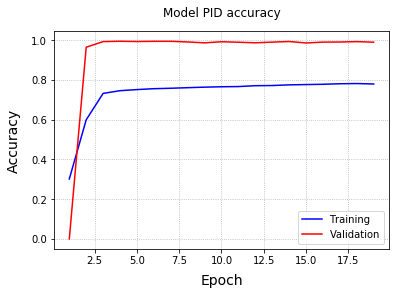

In [17]:
fig5 = plt.figure(5)
plt.plot(n_epochs, train_pid_acc, '-b', label='Training')
plt.plot(n_epochs, val_pid_acc, '-r', label='Validation')

plt.title('Model PID accuracy', y=1.04)
plt.grid(linestyle=':')
plt.xlabel('Epoch', labelpad=8, fontsize=14)
plt.ylabel('Accuracy', labelpad=10, fontsize=14)
plt.legend(loc='lower right')
plt.savefig(plot_dir + model_name + '_pid_accuracy.pdf', format='pdf')
fig5.show()

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


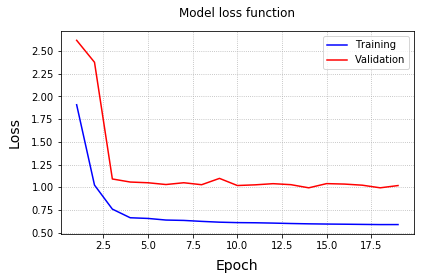

In [18]:
fig6 = plt.figure(6)
plt.plot(n_epochs, train_loss, '-b', label='Training')
plt.plot(n_epochs, val_loss, '-r', label='Validation')

plt.title('Model loss function', y=1.04)
plt.grid(linestyle=':')
plt.xlabel('Epoch', labelpad=8, fontsize=14)
plt.ylabel('Loss', labelpad=10, fontsize=14)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(plot_dir + model_name + '_total_loss.pdf', format='pdf')
fig6.show()

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


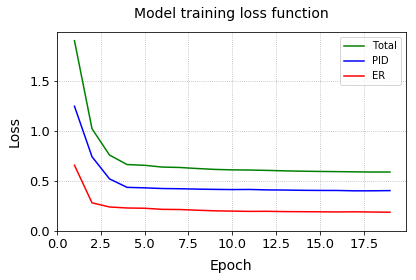

In [19]:
fig7 = plt.figure(7)
plt.plot(n_epochs, train_loss, '-g', label='Total')
plt.plot(n_epochs, train_pid_loss, '-b', label='PID')
plt.plot(n_epochs, train_en_loss, '-r', label='ER')
ax = plt.gca()
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.tick_params(axis = 'y', which = 'major', labelsize = 13)
plt.title('Model training loss function', y=1.04, fontsize=14)
plt.grid(linestyle=':')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel('Epoch', labelpad=8, fontsize=14)
plt.ylabel('Loss', labelpad=8, fontsize=14)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(plot_dir + model_name + '_training_loss.pdf', format='pdf')
fig7.show()

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


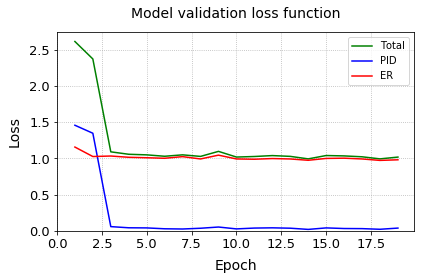

In [20]:
fig8 = plt.figure(8)
plt.plot(n_epochs, val_loss, '-g', label='Total')
plt.plot(n_epochs, val_pid_loss, '-b', label='PID')
plt.plot(n_epochs, val_en_loss, '-r', label='ER')
ax = plt.gca()
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.tick_params(axis = 'y', which = 'major', labelsize = 13)
plt.title('Model validation loss function', y=1.04, fontsize=14)
plt.grid(linestyle=':')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel('Epoch', labelpad=8, fontsize=14)
plt.ylabel('Loss', labelpad=8, fontsize=14)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(plot_dir + model_name + '_validation_loss.pdf', format='pdf')
fig8.show()

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


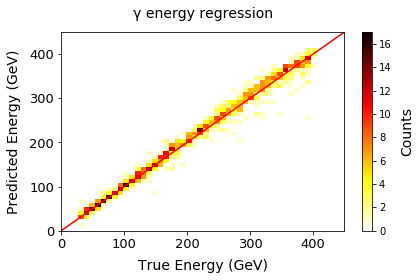

In [21]:
#gamma's energy hist
fig9 = plt.figure(9)
plt.hist2d(gamma_true_en, gamma_reco_en, (50,50), cmap='hot_r', range=[[0, 450], [0, 450]])
plt.title('γ energy regression', y=1.04, fontsize=14)
plt.xlabel('True Energy (GeV)', labelpad=8, fontsize=14)
plt.ylabel('Predicted Energy (GeV)', labelpad=8, fontsize=14)
ax = plt.gca()
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.tick_params(axis = 'y', which = 'major', labelsize = 13)
plt.plot([0,450],[0,450], color='red',linestyle='-')
# plt.grid(linestyle=':')
cbar = plt.colorbar()
cbar.set_label('Counts', fontsize=14, labelpad=8)
plt.tight_layout()
plt.savefig(plot_dir + model_name + '_gammaEnHist.pdf', format='pdf')
fig9.show()

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


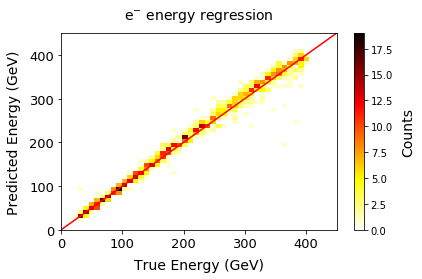

In [22]:
#electron's energy hist
fig10 = plt.figure(10)
plt.hist2d(electron_true_en, electron_reco_en, (50,50), cmap='hot_r', range=[[0, 450], [0, 450]])
plt.title('e$^{-}$ energy regression', y=1.04, fontsize=14)
plt.xlabel('True Energy (GeV)', labelpad=8, fontsize=14)
plt.ylabel('Predicted Energy (GeV)', labelpad=8, fontsize=14)
plt.xlim(0,450)
plt.ylim(0,450)
ax = plt.gca()
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.tick_params(axis = 'y', which = 'major', labelsize = 13)
plt.plot([0,450],[0,450], color='red',linestyle='-')
# plt.grid(linestyle=':')
cbar = plt.colorbar()
cbar.set_label('Counts', fontsize=14, labelpad=8)
plt.tight_layout()
plt.savefig(plot_dir + model_name + '_electronEnHist.pdf', format='pdf')
fig10.show()

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


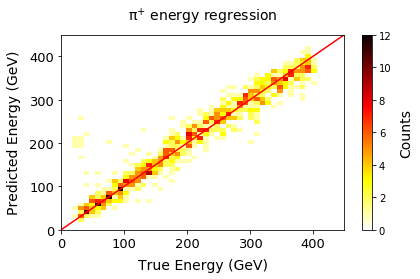

In [23]:
#pion's energy hist
fig11 = plt.figure(11)
plt.hist2d(pion_c_true_en, pion_c_reco_en, (50,50), cmap='hot_r', range=[[0, 450], [0, 450]])
plt.title('π$^{+}$ energy regression', y=1.04, fontsize=14)
plt.xlabel('True Energy (GeV)', labelpad=8, fontsize=14)
plt.ylabel('Predicted Energy (GeV)', labelpad=8, fontsize=14)
plt.xlim(0,450)
plt.ylim(0,450)
ax = plt.gca()
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.tick_params(axis = 'y', which = 'major', labelsize = 13)
plt.plot([0,450],[0,450], color='red',linestyle='-')
# plt.grid(linestyle=':')
cbar = plt.colorbar()
cbar.set_label('Counts', fontsize=14, labelpad=8)
plt.tight_layout()
plt.savefig(plot_dir + model_name + '_pion_cEnHist.pdf', format='pdf')
fig11.show()